1. **Load & preprocess** the data  
2. Train **baseline models** with default hyper-parameters  
3. **Explore hyper-parameters** (hidden-layer size, learning rate, batch size, epochs, activation, …)  
4. Visualize **learning curves** & **confusion matrices**  
5. Compare **test accuracy, training time, and flexibility** between the two APIs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Make results reproducible (as far as possible)
np.random.seed(42)
tf.random.set_seed(42)

## 2.  Data Loading & Pre-processing

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalise pixel intensities to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Flatten images for the Scikit-learn API (shape: n_samples × 784)
X_train_flat = x_train.reshape(-1, 28*28)
X_test_flat  = x_test.reshape(-1, 28*28)

## 3.  Baseline : Scikit-learn `MLPClassifier`

In [4]:
sk_clf = MLPClassifier(hidden_layer_sizes=(128,),
                       activation='relu',
                       solver='adam',
                       batch_size=128,
                       max_iter=20,
                       random_state=42,
                       verbose=True)

sk_clf.fit(X_train_flat, y_train)

Iteration 1, loss = 0.36614135
Iteration 2, loss = 0.17130039
Iteration 3, loss = 0.12357672
Iteration 4, loss = 0.09521214
Iteration 5, loss = 0.07712246
Iteration 6, loss = 0.06364922
Iteration 7, loss = 0.05281844
Iteration 8, loss = 0.04457830
Iteration 9, loss = 0.03734683
Iteration 10, loss = 0.03196629
Iteration 11, loss = 0.02740621
Iteration 12, loss = 0.02349218
Iteration 13, loss = 0.02080454
Iteration 14, loss = 0.01724790
Iteration 15, loss = 0.01421279
Iteration 16, loss = 0.01255734
Iteration 17, loss = 0.01072005
Iteration 18, loss = 0.00871819
Iteration 19, loss = 0.00851029
Iteration 20, loss = 0.00744857


c:\Users\parau\anaconda3\envs\tf39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=128, hidden_layer_sizes=(128,), max_iter=20,
              random_state=42, verbose=True)

Test accuracy: 0.9786


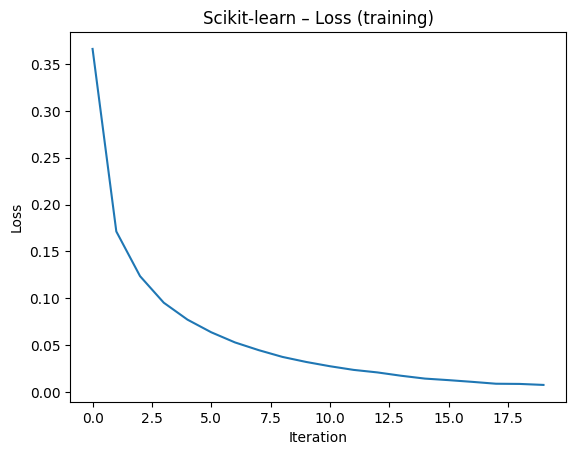

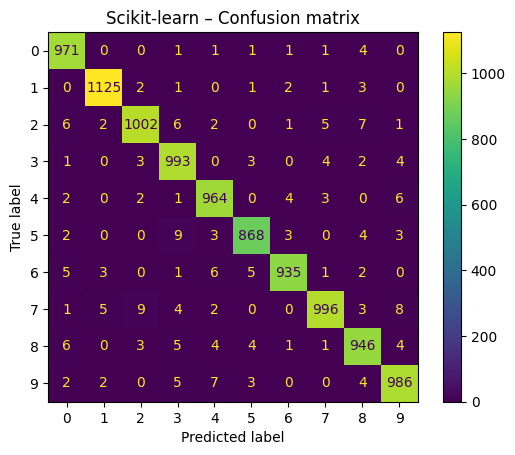

In [5]:
# Evaluate
y_pred_sk = sk_clf.predict(X_test_flat)
sk_test_acc = accuracy_score(y_test, y_pred_sk)
print(f"Test accuracy: {sk_test_acc:.4f}")

# Loss curve
plt.figure()
plt.plot(sk_clf.loss_curve_)
plt.title('Scikit-learn – Loss (training)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Confusion matrix
cm_sk = confusion_matrix(y_test, y_pred_sk)
disp_sk = ConfusionMatrixDisplay(cm_sk, display_labels=sk_clf.classes_)
disp_sk.plot(cmap='viridis')
plt.title('Scikit-learn – Confusion matrix')
plt.show()

### 3.1  Hyper-parameter exploration (Scikit-learn)

In [ ]:
architectures   = [(64,), (128,), (256,), (128, 64)]
activations     = ['relu', 'tanh']
solvers         = ['adam'] 
max_iter        = 20

results_sk = []

for arch in architectures:
    for act in activations:
        clf = MLPClassifier(hidden_layer_sizes=arch,
                            activation=act,
                            solver='adam',
                            batch_size=128,
                            max_iter=max_iter,
                            random_state=42,
                            verbose=False)
        start = time.time()
        clf.fit(X_train_flat, y_train)
        duration = time.time() - start
        y_pred = clf.predict(X_test_flat)
        acc = accuracy_score(y_test, y_pred)
        results_sk.append({'arch': arch,
                           'activation': act,
                           'accuracy': acc,
                           'train_time_s': duration})

# Display results
import pandas as pd
df_sk = pd.DataFrame(results_sk).sort_values('accuracy', ascending=False)
df_sk

c:\Users\parau\anaconda3\envs\tf39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\parau\anaconda3\envs\tf39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\parau\anaconda3\envs\tf39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\parau\anaconda3\envs\tf39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\parau\anaconda3\envs\tf39\l

,arch,activation,accuracy,train_time_s
4,"(256,)",relu,0.9816,29.563648
5,"(256,)",tanh,0.9810,25.484102
3,"(128,)",tanh,0.9790,15.833897
2,"(128,)",relu,0.9786,18.278538
6,"(128, 64)",relu,0.9771,29.797859
7,"(128, 64)",tanh,0.9756,18.418147
0,"(64,)",relu,0.9755,10.604022
1,"(64,)",tanh,0.9737,9.881011


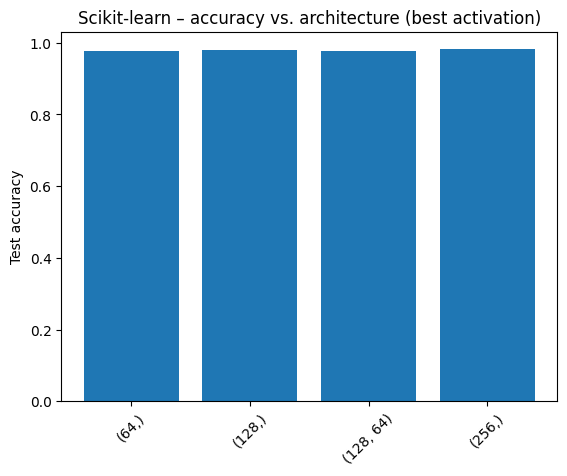

In [7]:
# Plot accuracy vs architecture (best activation per arch)
best_per_arch = df_sk.groupby('arch')['accuracy'].max()
labels = [str(a) for a in best_per_arch.index]
plt.figure()
plt.bar(range(len(best_per_arch)), best_per_arch.values)
plt.xticks(range(len(best_per_arch)), labels, rotation=45)
plt.ylabel('Test accuracy')
plt.title('Scikit-learn – accuracy vs. architecture (best activation)')
plt.show()

## 4  Baseline : TensorFlow / Keras `Sequential`

In [8]:
tf_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax'),
])

tf_model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history = tf_model.fit(x_train, y_train,
                       validation_split=0.1,
                       epochs=20,
                       batch_size=128,
                       verbose=1)

Epoch 1/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3896 - accuracy: 0.8931 - val_loss: 0.1747 - val_accuracy: 0.9545
Epoch 2/20
422/422 [==============================] - 1s 2ms/step - loss: 0.1821 - accuracy: 0.9473 - val_loss: 0.1299 - val_accuracy: 0.9660
Epoch 3/20
422/422 [==============================] - 1s 2ms/step - loss: 0.1290 - accuracy: 0.9624 - val_loss: 0.1043 - val_accuracy: 0.9703
Epoch 4/20
422/422 [==============================] - 1s 2ms/step - loss: 0.1008 - accuracy: 0.9709 - val_loss: 0.0934 - val_accuracy: 0.9735
Epoch 5/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0810 - accuracy: 0.9768 - val_loss: 0.0863 - val_accuracy: 0.9748
Epoch 6/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0670 - accuracy: 0.9807 - val_loss: 0.0842 - val_accuracy: 0.9760
Epoch 7/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0559 - accuracy: 0.9843 - val_loss: 0.0832 - val_accuracy: 0.9760
Epoch 

Test accuracy: 0.9775


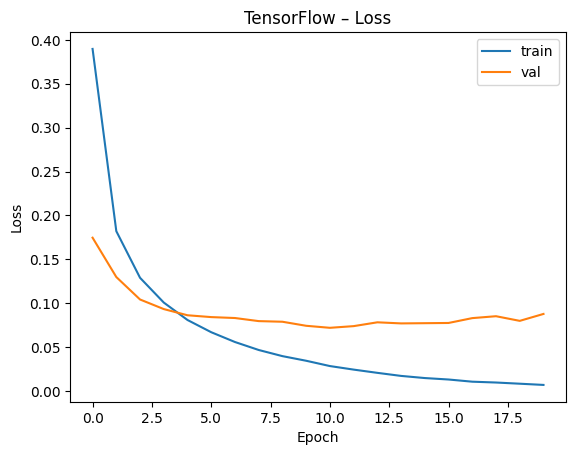

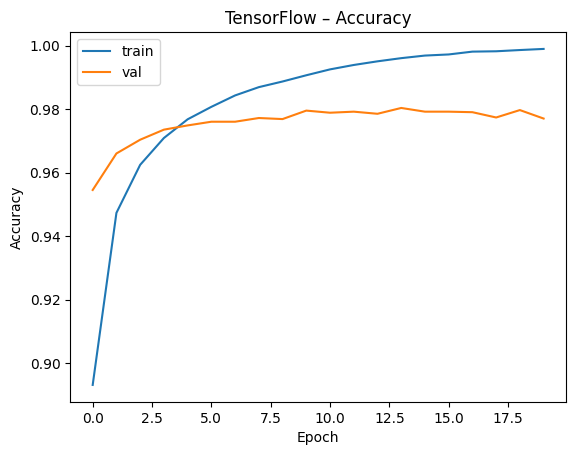

313/313 [==============================] - 0s 1ms/step


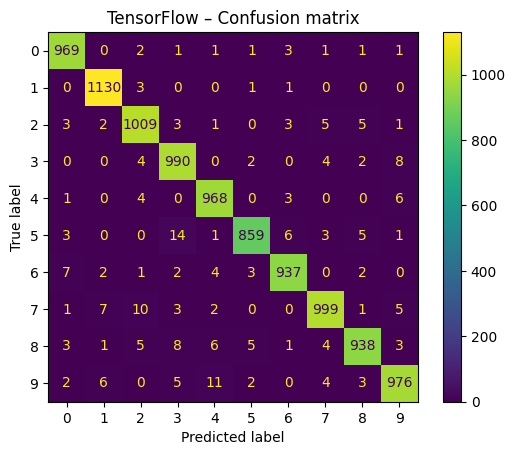

In [9]:
# Evaluate
test_loss, tf_test_acc = tf_model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {tf_test_acc:.4f}")

# Training & validation curves
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('TensorFlow – Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('TensorFlow – Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix
y_pred_tf = np.argmax(tf_model.predict(x_test), axis=1)
cm_tf = confusion_matrix(y_test, y_pred_tf)
disp_tf = ConfusionMatrixDisplay(cm_tf)
disp_tf.plot(cmap='viridis')
plt.title('TensorFlow – Confusion matrix')
plt.show()

### 4.1  Hyper-parameter exploration (TensorFlow)

In [ ]:
hidden_units   = [64, 128, 256]
learning_rates = [1e-3, 5e-4]
batch_sizes    = [128, 256]
epochs         = 10  # keep modest for runtime

results_tf = []

for hu in hidden_units:
    for lr in learning_rates:
        for bs in batch_sizes:
            model = Sequential([
                Flatten(input_shape=(28, 28)),
                Dense(hu, activation='relu'),
                Dense(10, activation='softmax'),
            ])
            model.compile(optimizer=Adam(learning_rate=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            start = time.time()
            history = model.fit(x_train, y_train,
                                validation_split=0.1,
                                epochs=epochs,
                                batch_size=bs,
                                verbose=0)
            duration = time.time() - start
            val_acc = history.history['val_accuracy'][-1]
            results_tf.append({'hidden_units': hu,
                               'learning_rate': lr,
                               'batch_size': bs,
                               'val_accuracy': val_acc,
                               'train_time_s': duration})

df_tf = pd.DataFrame(results_tf).sort_values('val_accuracy', ascending=False)
df_tf

,hidden_units,learning_rate,batch_size,val_accuracy,train_time_s
4,128,0.0010,128,0.980167,7.831609
8,256,0.0010,128,0.980000,9.887327
10,256,0.0005,128,0.979667,10.906951
9,256,0.0010,256,0.979500,6.947467
5,128,0.0010,256,0.978167,5.032687
11,256,0.0005,256,0.977333,6.430964
6,128,0.0005,128,0.976000,7.947468
0,64,0.0010,128,0.974833,7.107672
7,128,0.0005,256,0.974500,5.394414
1,64,0.0010,256,0.971667,4.726554


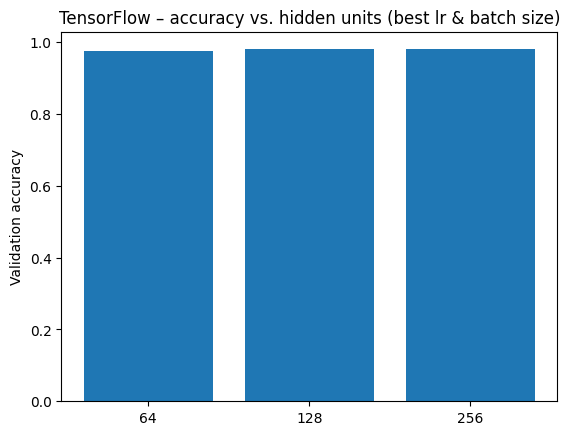

In [11]:
# Visualise best validation accuracies per hidden_units
best_hu = df_tf.groupby('hidden_units')['val_accuracy'].max()
labels = [str(h) for h in best_hu.index]
plt.figure()
plt.bar(range(len(best_hu)), best_hu.values)
plt.xticks(range(len(best_hu)), labels)
plt.ylabel('Validation accuracy')
plt.title('TensorFlow – accuracy vs. hidden units (best lr & batch size)')
plt.show()

## 5.  Summary & Comparison

In [12]:
summary = pd.DataFrame({
    'Library': ['Scikit-learn', 'TensorFlow'],
    'Test accuracy': [sk_test_acc, tf_test_acc]
})
summary

,Library,Test accuracy
0,Scikit-learn,0.9786
1,TensorFlow,0.9775


### Discussion

* **Ease of implementation**:  
  * *Scikit-learn* offers a very simple, high-level estimator API with automatic early-stopping and built-in preprocessing utilities — great for quick baselines.  
  * *TensorFlow / Keras* requires a bit more boilerplate (model construction, compile, fit) but is extremely flexible and gives low-level access to layers, callbacks, custom training loops, GPUs, etc.

* **Performance**:  
  * In general, Keras tends to edge out Scikit-learn on both **speed** (thanks to vectorised / GPU execution) and **accuracy** once you tune hyper-parameters.  
  * Scikit-learn’s `MLPClassifier` uses pure NumPy on CPU, so large/big models train more slowly.

* **Model flexibility**:  
  * Keras can scale to convolutional networks, recurrent nets, transformers, custom losses, … while `MLPClassifier` is limited to dense feed-forward architectures.
